In [1]:
import sklearn
assert sklearn.__version__=='0.23.2', 'Posible problema de version en sklearn'

## Importación de librerías

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from scipy.io import arff
import random
from collections import OrderedDict
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve
## sklearn-optimize es tomado de: https://github.com/senolakkas/sklearn-optimize
from sklearn_genetic.genetic import GeneticSearchCV
from deap import base, creator, tools, algorithms
from sklearn.base import clone, is_classifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import joblib
from tabulate import tabulate
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

C:\Users\lmes_\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# GeneticSearchCV modificado
class GeneticSearchCVMod(GeneticSearchCV):
     def __init__(self, estimator, params, scoring=None, cv=4,
                 refit=True, verbose=False, population_size=50,
                 gene_mutation_prob=0.1, gene_crossover_prob=0.5,
                 tournament_size=3, generations_number=10, gene_type=None,
                 n_jobs=1, iid=True, error_score='raise',
                 fit_params={}):
        super(GeneticSearchCV, self).__init__(
            estimator=estimator, scoring=scoring,
            iid=iid, refit=refit, cv=cv, verbose=verbose,
            error_score=error_score)
        self.fit_params=fit_params
        self.params = params
        self.population_size = population_size
        self.generations_number = generations_number
        self._individual_evals = {}
        self.gene_mutation_prob = gene_mutation_prob
        self.gene_crossover_prob = gene_crossover_prob
        self.tournament_size = tournament_size
        self.gene_type = gene_type
        self.all_history_, self.all_logbooks_ = [], []
        self._cv_results = None
        self.best_score_ = None
        self.best_params_ = None
        self.score_cache = {}
        self.n_jobs = n_jobs
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, est=clone(self.estimator), fitness=creator.FitnessMax)

## Lectura de modelos guardados

In [4]:
param_ga = {"kernel": ["rbf", "sigmoid", "linear"],
             "C": np.logspace(-2, 2, num=10, base=10),
             "gamma": np.logspace(-2, 2, num=10, base=10)}
cv_svm_ga_model = GeneticSearchCVMod(estimator=SVC(probability=True),
                     params=param_ga,
                     scoring="recall",
                     cv=5,
                     verbose=1,
                     population_size=20,
                     gene_mutation_prob=0.10,
                     gene_crossover_prob=0.5,
                     tournament_size=3,
                     generations_number=5,
                     n_jobs=4)

In [5]:
# cargamos los modelos
dt_model = joblib.load(os.path.join('modelos','Modelo_DT.pkl'))
lr_model = joblib.load(os.path.join('modelos','Modelo_LR.pkl'))
rf_model = joblib.load(os.path.join('modelos','Modelo_RF.pkl'))
xgb_model = joblib.load(os.path.join('modelos','Modelo_XGB.pkl'))
cv_svm_model = joblib.load(os.path.join('modelos','Modelo_SVM.pkl'))
svm_model = cv_svm_model.best_estimator_
cs_svm_ga_model = joblib.load(os.path.join('modelos','Modelo_GA_SVM.pkl'))
svm_ga_model = cs_svm_ga_model.best_estimator_

## Lectura de dataset imputado

In [6]:
# se carga dataset imputado
imputed_df = pd.read_pickle(os.path.join('results','dataset_normalizado.pkl'))

In [7]:
# función para separar las columnas en variables y etiquetas ('flag')
def split_features_labels(df):
    feature_dfs = df.iloc[:, :-1]
    label_dfs = df['flag']
    return feature_dfs, label_dfs

## Evaluación de modelos

In [8]:
def save_and_show_resultados(descripcion, model, resultados, X_train, X_test, y_train, y_test):
  y_train_pred = model.predict(X_train)
  y_train_pred_proba = model.predict_proba(X_train)[:,1]

  y_test_pred = model.predict(X_test)
  y_test_pred_proba = model.predict_proba(X_test)[:,1]

  confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
  confusion_matrix_test = confusion_matrix(y_test, y_test_pred)

  resultados.update( { descripcion: {
      ('Entrenamiento', 'Exactitud'): model.score(X_train, y_train),
      ('Entrenamiento', 'Exhaustividad'): recall_score(y_train, y_train_pred),
      ('Entrenamiento', 'F1'): f1_score(y_train, y_train_pred),
      ('Entrenamiento', 'AUC'): roc_auc_score(y_train, y_train_pred_proba),
      ('Entrenamiento', 'TypeI'): confusion_matrix_train[0][1],
      ('Pruebas', 'Exactitud'): model.score(X_test, y_test),
      ('Pruebas', 'Exhaustividad'): recall_score(y_test, y_test_pred),
      ('Pruebas', 'F1'): f1_score(y_test, y_test_pred),
      ('Pruebas', 'AUC'): roc_auc_score(y_test, y_test_pred_proba),
      ('Pruebas', 'TypeI'): confusion_matrix_test[0][1]
    } } )
  fig, axes = plt.subplots(1, 3, figsize=(18, 5))
  fig.suptitle(f'{descripcion} (Conjunto de Pruebas)')
  plot_confusion_matrix(model, X_test, y_test, ax=axes[0], values_format='d')
  plot_roc_curve(model, X_test, y_test, ax=axes[1], name=descripcion)
  plot_precision_recall_curve(model, X_test, y_test, ax=axes[2], name=descripcion)
  return

In [9]:
def tabla_resultados(resultados):
  df = pd.DataFrame.from_dict(resultados, orient='index')
  display(df)
  return df

In [10]:
# Modelamiento de la data usando un diccionario de datasets y modelos
def perform_data_evaluation(modelos, imputed_df):
    # to show table
    resultados = {}

    # hacemos la division del dataframe en variables y etiquetas
    X, y = split_features_labels(imputed_df)

    # Dividimos la data en test y train
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    test_size = 0.2,
                                                    random_state = 1)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,test_size = 0.2,random_state=1)
    # Iteramos sobre los clasificadores
    for model_name, clf in modelos.items():
       
        # actualiza resultados
        save_and_show_resultados(model_name, clf, resultados, X_train, X_test, y_train, y_test)

    # presentamos la tabla resumen
    tabla_results = tabla_resultados(resultados)

    return tabla_results

## Análisis comparativo

In [11]:
# models
models_dictionary2 = OrderedDict()
models_dictionary2['SVM'] = svm_model
models_dictionary2['SVM+GA'] = svm_ga_model
models_dictionary2['DT'] = dt_model
models_dictionary2['LR'] = lr_model
models_dictionary2['RF'] = rf_model
models_dictionary2['XGB'] = xgb_model

**Comparación**

Entrenamiento                                           Pruebas  \
           Exactitud Exhaustividad        F1       AUC TypeI Exactitud   
SVM         0.972869      0.170455  0.288462  0.956460     2  0.974340   
SVM+GA      0.993767      0.812500  0.893750  0.990099     1  0.987537   
DT          0.973786      0.312500  0.434783  0.888314    22  0.973607   
LR          0.972869      0.261364  0.383333  0.951310    18  0.968475   
RF          0.970486      0.085227  0.157068  0.955802     0  0.969208   
XGB         1.000000      1.000000  1.000000  1.000000     0  0.972141   

                                                
       Exhaustividad        F1       AUC TypeI  
SVM         0.204545  0.339623  0.958953     0  
SVM+GA      0.636364  0.767123  0.975207     1  
DT          0.227273  0.357143  0.874518     2  
LR          0.181818  0.271186  0.885158     7  
RF          0.045455  0.086957  0.943457     0  
XGB         0.227273  0.344828  0.923192     4

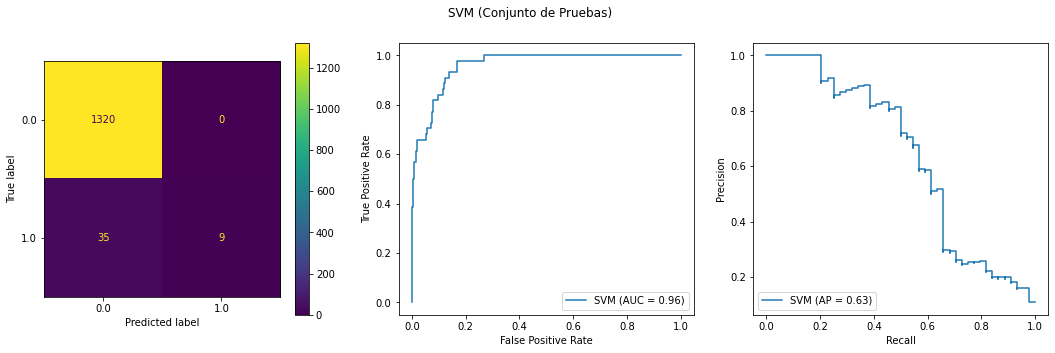

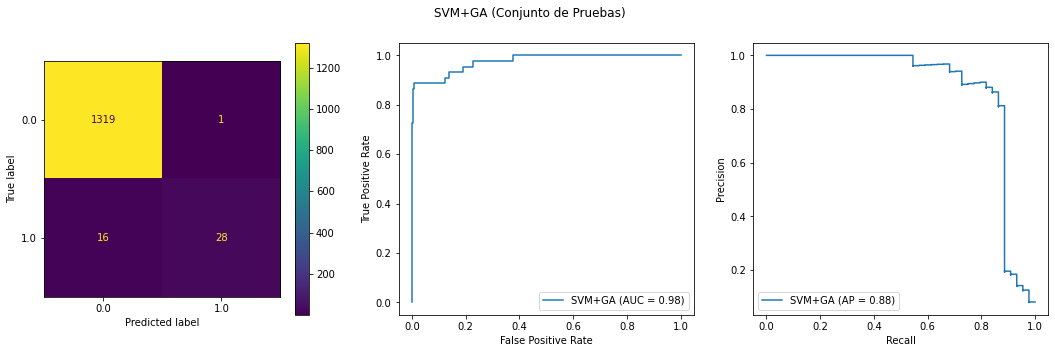

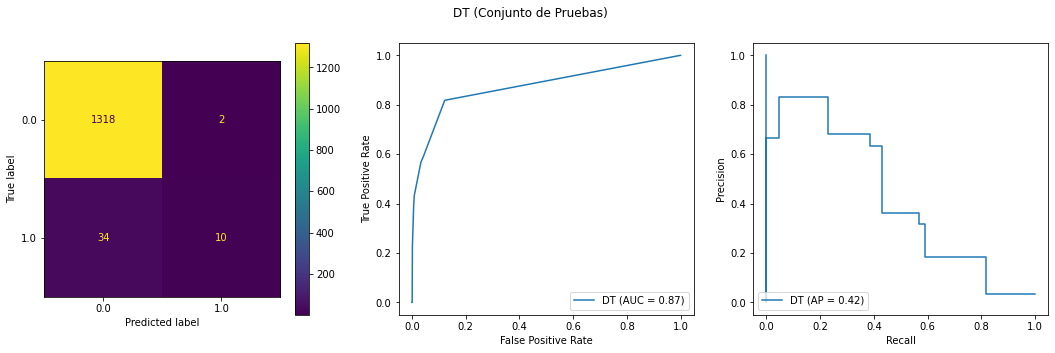

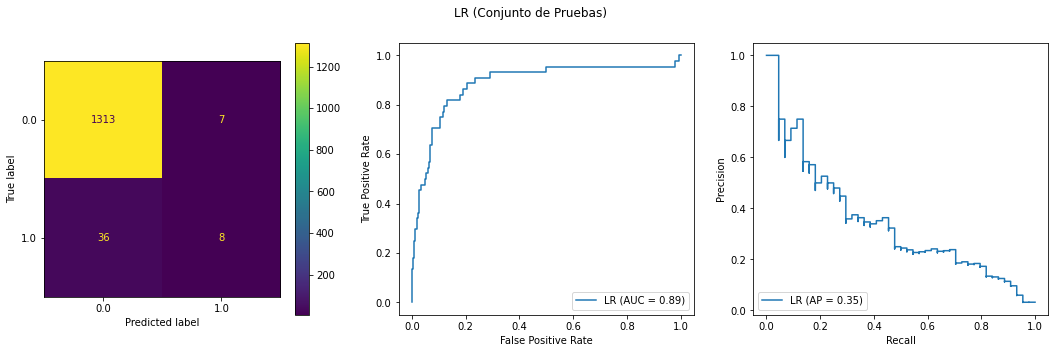

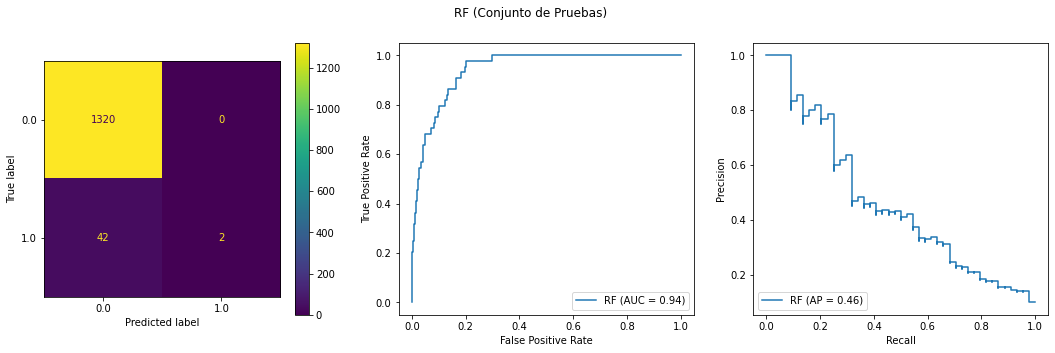

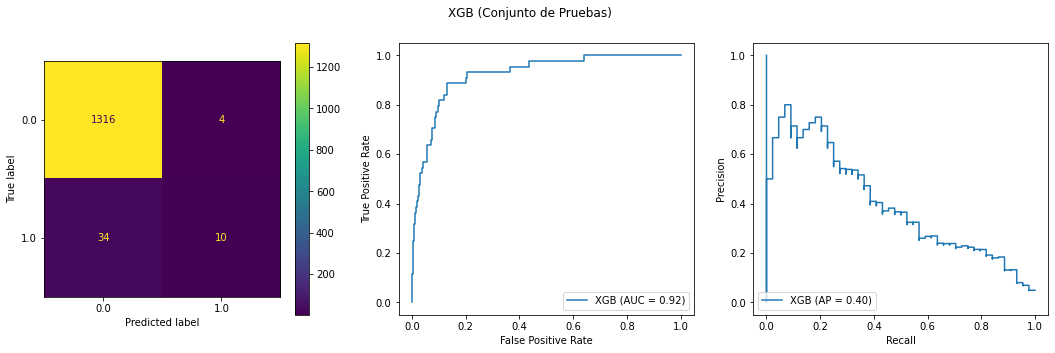

In [12]:
# Verificamos validación para comparación
metricas = perform_data_evaluation(models_dictionary2, imputed_df)

## Modelo Ensamble

In [13]:
X, y = split_features_labels(imputed_df)

# Dividimos la data en test y train
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,test_size = 0.2,random_state=1)

In [14]:
estimators = [
     ('SVM+GA', svm_ga_model),
     ('SVM', svm_model),
     ('XGBoost', xgb_model),
     ('RF', rf_model)
]

ensamble = StackingClassifier(estimators=estimators, 
                              final_estimator=LogisticRegression(penalty='l2') )
ensamble.fit(X_train, y_train)

StackingClassifier(estimators=[('SVM+GA',
                                SVC(C=12.915496650148826,
                                    gamma=0.027825594022071243,
                                    probability=True)),
                               ('SVM',
                                SVC(C=100, gamma=0.001, probability=True)),
                               ('XGBoost',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1,
                                              eval_metric='error', gamma=0,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_co...
                                              min_child_weight=1, missing=nan,
                                           

In [15]:
# models
models_dictionary = OrderedDict()
models_dictionary['Ensamble'] = ensamble
models_dictionary['SVM'] = svm_model
models_dictionary['SVM+GA'] = svm_ga_model
models_dictionary['DT'] = dt_model
models_dictionary['LR'] = lr_model
models_dictionary['RF'] = rf_model
models_dictionary['XGB'] = xgb_model

Entrenamiento                                           Pruebas  \
             Exactitud Exhaustividad        F1       AUC TypeI Exactitud   
Ensamble      0.995784      0.869318  0.930091  1.000000     0  0.972874   
SVM           0.972869      0.170455  0.288462  0.956460     2  0.974340   
SVM+GA        0.993767      0.812500  0.893750  0.990099     1  0.987537   
DT            0.973786      0.312500  0.434783  0.888314    22  0.973607   
LR            0.972869      0.261364  0.383333  0.951310    18  0.968475   
RF            0.970486      0.085227  0.157068  0.955802     0  0.969208   
XGB           1.000000      1.000000  1.000000  1.000000     0  0.972141   

                                                  
         Exhaustividad        F1       AUC TypeI  
Ensamble      0.250000  0.372881  0.924122     4  
SVM           0.204545  0.339623  0.958953     0  
SVM+GA        0.636364  0.767123  0.975207     1  
DT            0.227273  0.357143  0.874518     2  
LR            0.181818  0.271186  0.885158     7  
RF            0.045455  0.086957  0.943457     0  
XGB           0.227273  0.344828  0.923192     4

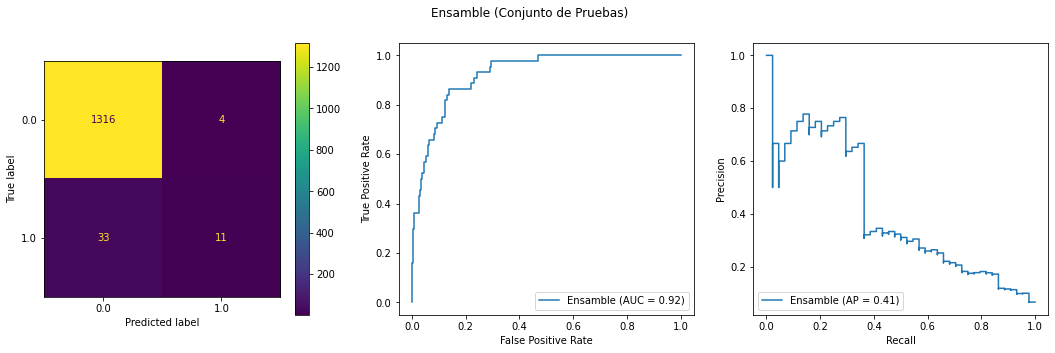

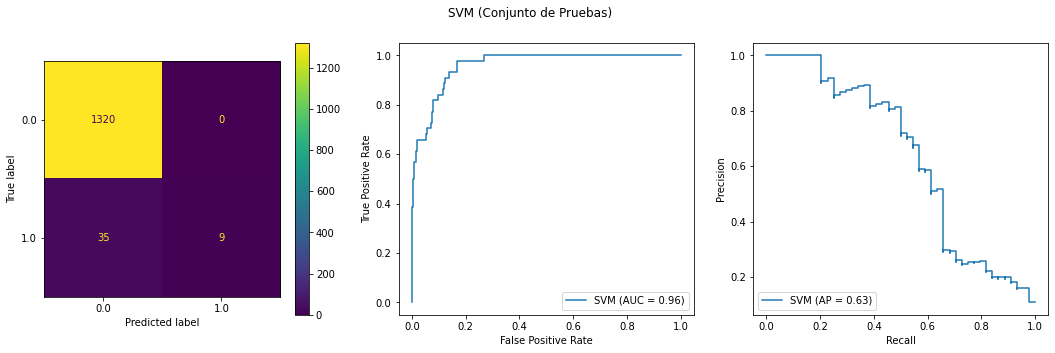

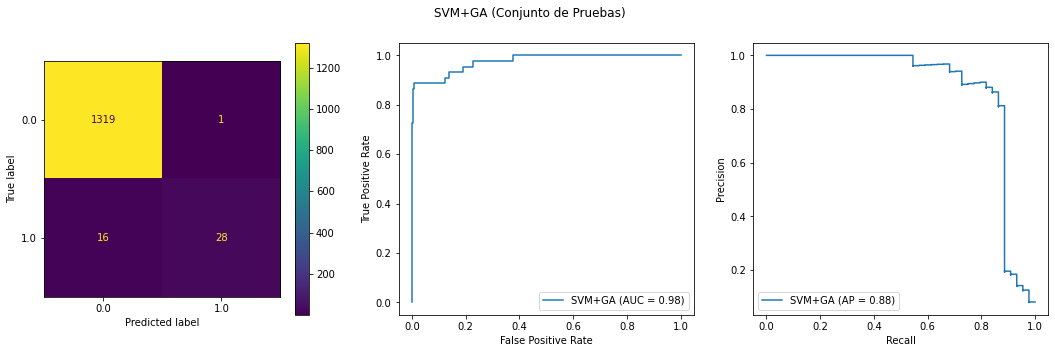

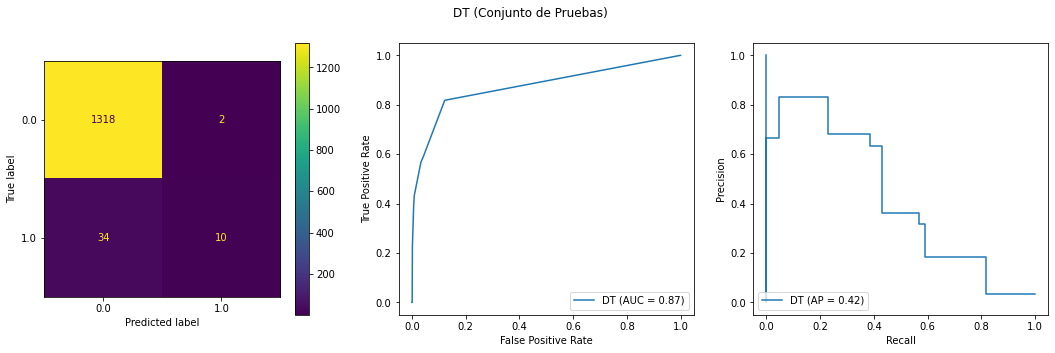

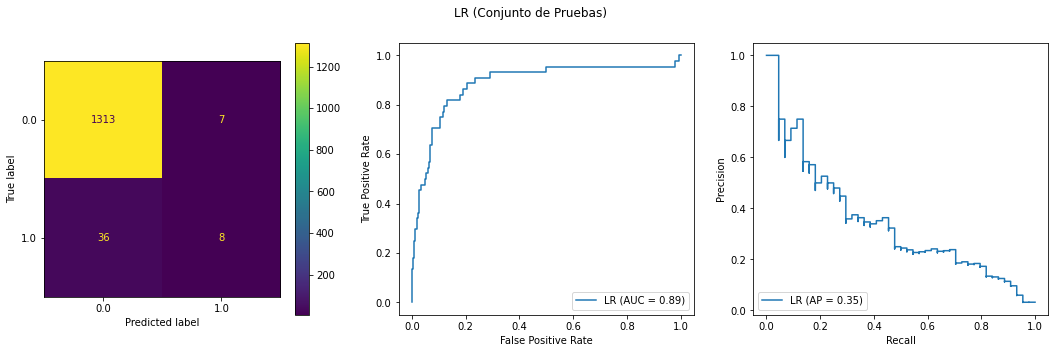

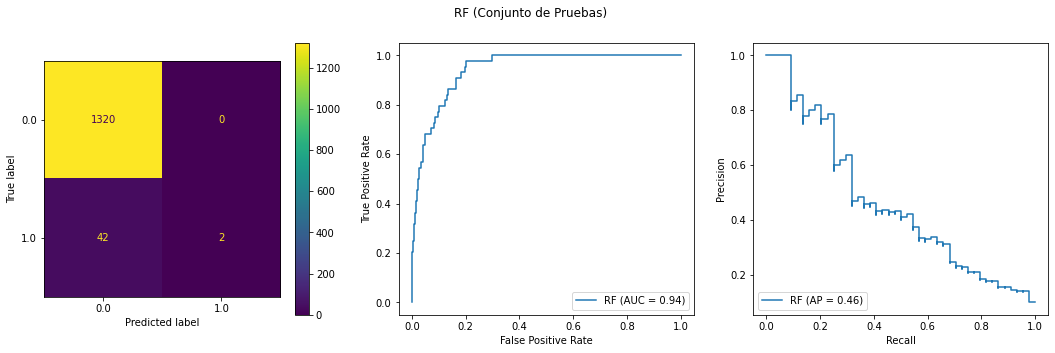

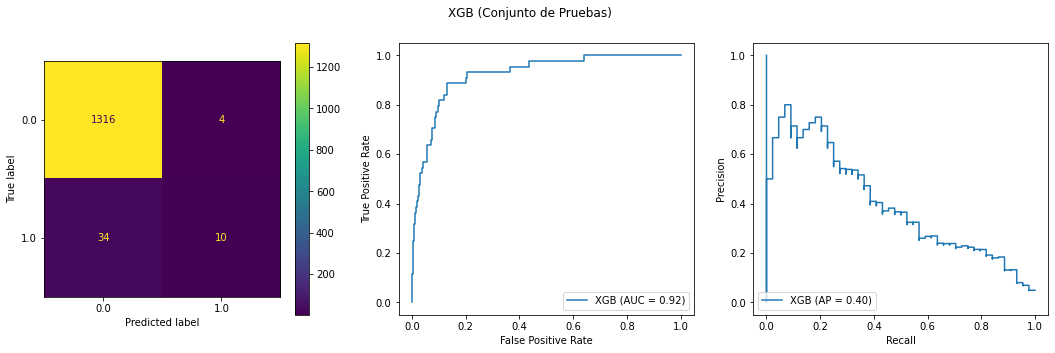

In [16]:
# Verificamos validación para comparación
metricas = perform_data_evaluation(models_dictionary, imputed_df)

**Tablas**

In [17]:
print(metricas.to_latex(index=False))  

\begin{tabular}{rrrrrrrrrr}
\toprule
Entrenamiento & \multicolumn{5}{l}{Pruebas} \\
    Exactitud & Exhaustividad &        F1 &       AUC & TypeI & Exactitud & Exhaustividad &        F1 &       AUC & TypeI \\
\midrule
     0.995784 &      0.869318 &  0.930091 &  1.000000 &     0 &  0.972874 &      0.250000 &  0.372881 &  0.924122 &     4 \\
     0.972869 &      0.170455 &  0.288462 &  0.956460 &     2 &  0.974340 &      0.204545 &  0.339623 &  0.958953 &     0 \\
     0.993767 &      0.812500 &  0.893750 &  0.990099 &     1 &  0.987537 &      0.636364 &  0.767123 &  0.975207 &     1 \\
     0.973786 &      0.312500 &  0.434783 &  0.888314 &    22 &  0.973607 &      0.227273 &  0.357143 &  0.874518 &     2 \\
     0.972869 &      0.261364 &  0.383333 &  0.951310 &    18 &  0.968475 &      0.181818 &  0.271186 &  0.885158 &     7 \\
     0.970486 &      0.085227 &  0.157068 &  0.955802 &     0 &  0.969208 &      0.045455 &  0.086957 &  0.943457 &     0 \\
     1.000000 &      1.000000 & 

## Producción de gráficos

In [ ]:
metricas.unstack()['Pruebas']['Exactitud'].plot(kind='bar',title='Exactitud')

<AxesSubplot:title={'center':'F1-score'}>

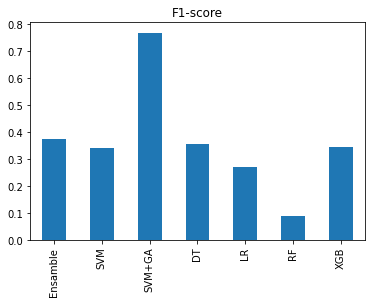

In [19]:
metricas.unstack()['Pruebas']['F1'].plot(kind='bar',title='F1-score')

<AxesSubplot:title={'center':'AUC'}>

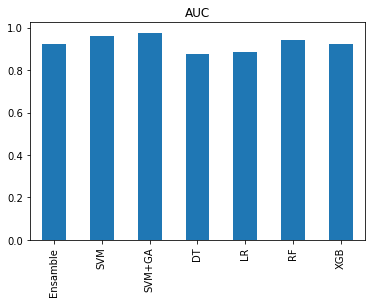

In [20]:
metricas.unstack()['Pruebas']['AUC'].plot(kind='bar',title='AUC')

<AxesSubplot:title={'center':'Type I'}>

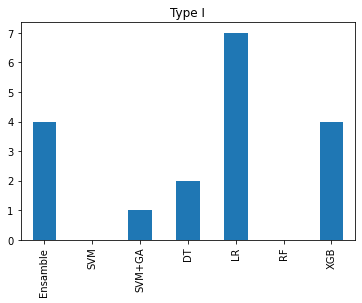

In [21]:
metricas.unstack()['Pruebas']['TypeI'].plot(kind='bar',title='Type I')

In [22]:
def ax_setup(ax):
    ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
    ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
    ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
    ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')
    

In [23]:
def save_and_show_resultados2(descripcion, model, resultados, X_train, X_test, y_train, y_test):
  y_train_pred = model.predict(X_train)
  y_train_pred_proba = model.predict_proba(X_train)[:,1]

  y_test_pred = model.predict(X_test)
  y_test_pred_proba = model.predict_proba(X_test)[:,1]

  confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
  confusion_matrix_test = confusion_matrix(y_test, y_test_pred)

  resultados.update( { descripcion: {
      ('Entrenamiento', 'Exactitud'): model.score(X_train, y_train),
      ('Entrenamiento', 'Exhaustividad'): recall_score(y_train, y_train_pred),
      ('Entrenamiento', 'F1'): f1_score(y_train, y_train_pred),
      ('Entrenamiento', 'AUC'): roc_auc_score(y_train, y_train_pred_proba),
      ('Entrenamiento', 'TypeI'): confusion_matrix_train[0][1],
      ('Pruebas', 'Exactitud'): model.score(X_test, y_test),
      ('Pruebas', 'Exhaustividad'): recall_score(y_test, y_test_pred),
      ('Pruebas', 'F1'): f1_score(y_test, y_test_pred),
      ('Pruebas', 'AUC'): roc_auc_score(y_test, y_test_pred_proba),
      ('Pruebas', 'TypeI'): confusion_matrix_test[0][1]
    } } )
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))
  ax_setup(axes[0])
  ax_setup(axes[1])
  fig.suptitle(f'{descripcion} (Conjunto de Pruebas)')
  plot_confusion_matrix(model, X_test, y_test, ax=axes[0], values_format='d')
  plot_roc_curve(model, X_test, y_test, ax=axes[1], name=descripcion)
  return

In [24]:
# Modelamiento de la data usando un diccionario de datasets y modelos
def perform_data_evaluation2(modelos, imputed_df):
    # to show table
    resultados = {}

    # hacemos la division del dataframe en variables y etiquetas
    X, y = split_features_labels(imputed_df)

    # Dividimos la data en test y train
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    test_size = 0.2,
                                                    random_state = 1)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,test_size = 0.2,random_state=1)
    # Iteramos sobre los clasificadores
    for model_name, clf in modelos.items():
       
        # actualiza resultados
        save_and_show_resultados2(model_name, clf, resultados, X_train, X_test, y_train, y_test)

    # presentamos la tabla resumen
    tabla_results = tabla_resultados(resultados)

    return tabla_results

Entrenamiento                                           Pruebas  \
             Exactitud Exhaustividad        F1       AUC TypeI Exactitud   
Ensamble      0.995784      0.869318  0.930091  1.000000     0  0.972874   
SVM           0.972869      0.170455  0.288462  0.956460     2  0.974340   
SVM+GA        0.993767      0.812500  0.893750  0.990099     1  0.987537   
DT            0.973786      0.312500  0.434783  0.888314    22  0.973607   
LR            0.972869      0.261364  0.383333  0.951310    18  0.968475   
RF            0.970486      0.085227  0.157068  0.955802     0  0.969208   
XGB           1.000000      1.000000  1.000000  1.000000     0  0.972141   

                                                  
         Exhaustividad        F1       AUC TypeI  
Ensamble      0.250000  0.372881  0.924122     4  
SVM           0.204545  0.339623  0.958953     0  
SVM+GA        0.636364  0.767123  0.975207     1  
DT            0.227273  0.357143  0.874518     2  
LR            0.181818  0.271186  0.885158     7  
RF            0.045455  0.086957  0.943457     0  
XGB           0.227273  0.344828  0.923192     4

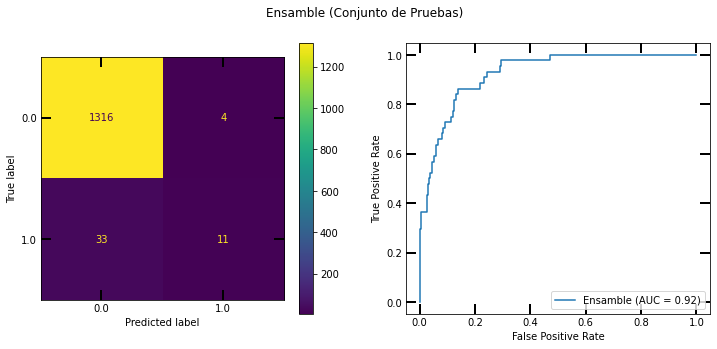

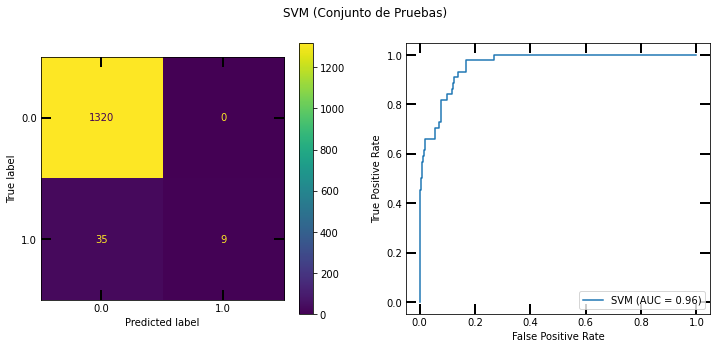

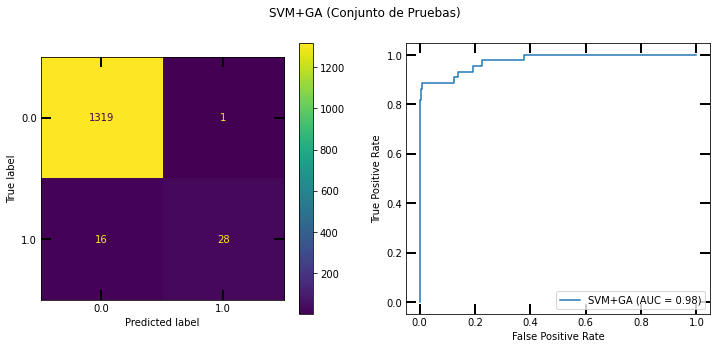

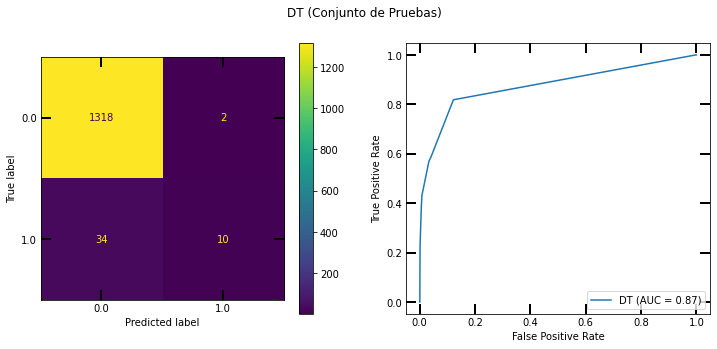

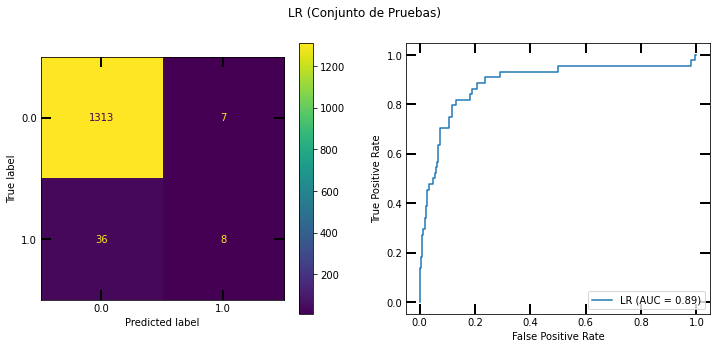

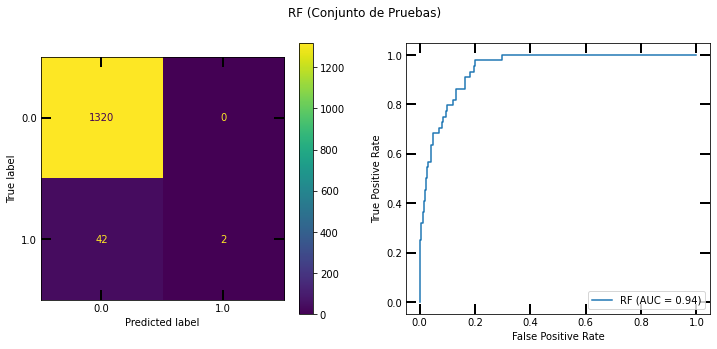

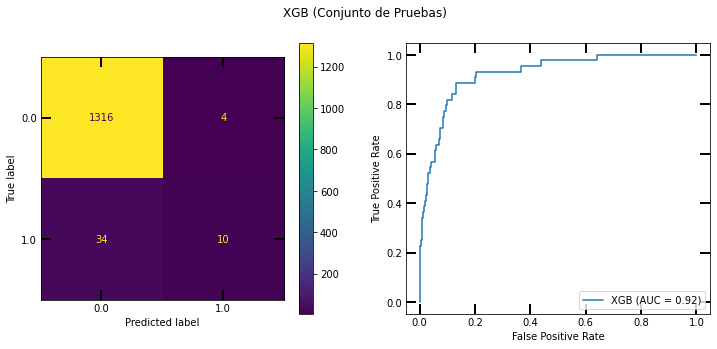

In [25]:
# Verificamos validación para comparación
metricas = perform_data_evaluation2(models_dictionary, imputed_df)